In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from general_graph_utils import *

In [560]:
G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5,6,7])
G.add_edges_from([(1,2),(2,1),(2,3),(3,2),(4,3),(3,4),(5,4),(4,5),(5,6),(6,5),(7,6),(6,7),(7,1),(1,7)])

In [561]:
G_ud = nx.Graph()
G_ud.add_nodes_from([1,2,3,4,5,6,7])
G_ud.add_edges_from([(1,2),(2,1),(2,3),(3,2),(4,3),(3,4),(5,4),(4,5),(5,6),(6,5),(7,6),(6,7),(7,1),(1,7)])

In [562]:
#n=9
#G,G_ud = random_graph(n)

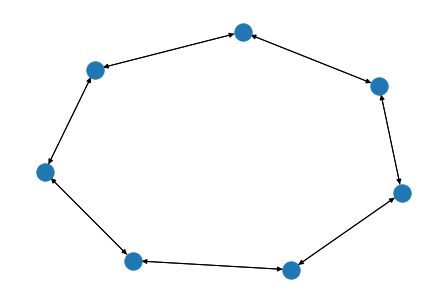

In [563]:
nx.draw(G)

In [564]:
def get_labels_ones(G):
    """
    Extracts the label information for each edge in a NetworkX graph object. If G not labeled, labels are logarithmically sampled.
    
    Note: works for undirected graph, but if given a choice, better to use a directed graph
    
    Parameters
    ----------
    G : NetworkX graph object (directed)
            
    Returns
    -------
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
        
    """
    
    label_dict = {}
    
    if nx.is_weighted(G)==True:
        for i in range(len(G.edges())):
            label_dict[list(G.edges())[i]] = G.get_edge_data(list(G.edges)[i][0],list(G.edges)[i][1])['weight']
        
    elif nx.is_weighted(G)==False:
        label_dict = {e: 1.0 for e in G.edges}
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [565]:
node_list = get_nodes(G)
edge_list = get_edges(G)
label_dict, label_list = get_labels_ones(G)
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)

In [566]:
print(label_dict)

{(1, 2): 1.0, (1, 7): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 3): 1.0, (4, 5): 1.0, (5, 4): 1.0, (5, 6): 1.0, (6, 5): 1.0, (6, 7): 1.0, (7, 6): 1.0, (7, 1): 1.0}


In [567]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [568]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [569]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [570]:
observable = make_observable(node_list)
tau_n = np.arange(start=0.01,stop=2.0,step=0.01)
L = Laplacian_all(edge_list, label_list, node_list)

In [571]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
print(np.abs(np.trapz(t)-np.trapz(t_rev)))

5.9117155615240335464e-11


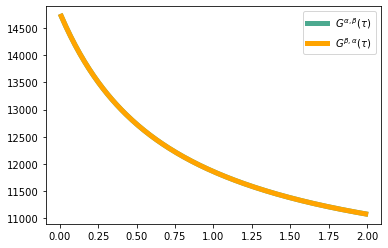

In [572]:
fig = plt.figure()
plt.plot(tau_n,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau_n,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()

In [573]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [574]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

In [575]:
print(label_dict)

{(1, 2): 1.0, (1, 7): 1.0, (2, 1): 1.0, (2, 3): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 3): 1.0, (4, 5): 1.0, (5, 4): 1.0, (5, 6): 1.0, (6, 5): 1.0, (6, 7): 1.0, (7, 6): 1.0, (7, 1): 1.0}


In [576]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)

In [577]:
t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
print(np.abs(np.trapz(t)-np.trapz(t_rev)))

5.9117155615240335464e-11


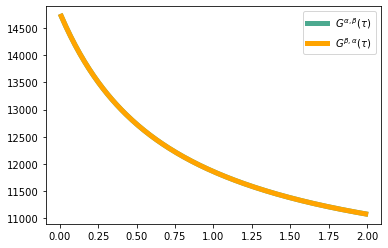

In [578]:
fig = plt.figure()
plt.plot(tau_n,t_rev,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau_n,t,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()

In [579]:
cycle_idx = np.random.choice(np.arange(num_cycles))

In [580]:
edge_idx = np.random.choice(np.arange(len(cycle_labels_forward[cycle_idx])))

In [581]:
param_choice = cycle_labels_forward[cycle_idx][edge_idx]
edge_choice = cycle_edges_forward[cycle_idx][edge_idx]
print(edge_choice)
print(param_choice)

(1, 2)
1.0


In [582]:
N = 2000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [583]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
    
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    t, t_rev = autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(t)-np.trapz(t_rev))
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|███████████████████████████████████████| 2000/2000 [06:07<00:00,  5.44it/s]


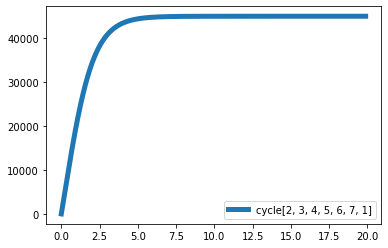

In [585]:
fig = plt.figure()
for i in range(0,num_cycles):
    plt.plot(all_affinities[:,i],all_areas,linewidth=5,label='cycle'+str(cycle_list[i]))
plt.legend()

In [ ]:
|